# Comparing Supervised Learning and RL Using Stock Data

(Insert explanation of our process here)

## Supervised Learning Approach

In [94]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Reading Stock Data

In [95]:
msft = pd.read_csv("./Individual_Stock_Data/MSFT.csv")

In [96]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


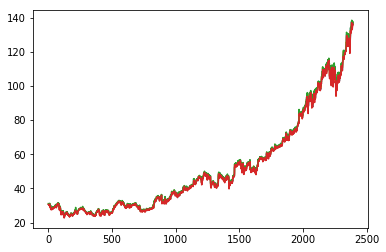

In [97]:
plt.figure()
plt.plot(msft["Open"])
plt.plot(msft["Close"])
plt.plot(msft["High"])
plt.plot(msft["Low"])
plt.show()

### Normalize Data

In [98]:
df_train, df_test = train_test_split(msft, train_size=0.8, test_size=0.2, shuffle=False)

In [100]:
df_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400
5,2010-01-11,30.71,30.76,30.12,30.27,23.99,68754700
6,2010-01-12,30.15,30.40,29.91,30.07,23.83,65912100
7,2010-01-13,30.26,30.52,30.01,30.35,24.05,51863500
8,2010-01-14,30.31,31.10,30.26,30.96,24.53,63228100
9,2010-01-15,31.08,31.24,30.71,30.86,24.45,79913200


In [101]:
df_test

,Date,Open,High,Low,Close,Adj Close,Volume
1913,2017-08-09,72.25,72.51,72.05,72.47,69.95,22213400
1914,2017-08-10,71.90,72.19,71.35,71.41,68.92,24734500
1915,2017-08-11,71.61,72.70,71.28,72.50,69.98,21443700
1916,2017-08-14,73.06,73.72,72.95,73.59,71.03,20096600
1917,2017-08-15,73.59,73.59,73.04,73.22,71.05,19181400
1918,2017-08-16,73.34,74.10,73.17,73.65,71.46,18150400
1919,2017-08-17,73.58,73.87,72.40,72.40,70.25,22977500
1920,2017-08-18,72.27,72.84,71.93,72.49,70.34,18761500
1921,2017-08-21,72.47,72.48,71.70,72.15,70.01,17734800
1922,2017-08-22,72.35,73.24,72.35,73.16,70.99,14343700
